In [1]:
import os
import random
import csv
import torch
from datasets import Dataset
from torch.utils.data import DataLoader
from tqdm import tqdm
from nnsight import LanguageModel
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
from einops import einsum, rearrange, reduce

from utils import get_both_stories, get_control_corrupt_data, get_altered_option_letters_data, get_data_pp

random.seed(10)

%load_ext autoreload
%autoreload 2

# Loading model

In [2]:
if os.environ.get("USER") == 'nikhil_prakash':
    model = LanguageModel(
        "/data/public_models/huggingface/meta-llama/Meta-Llama-3-70B-Instruct",
        device_map="auto",
        load_in_4bit=True,
        torch_dtype=torch.float16,
        dispatch=True,
    )
else:
    model = LanguageModel(
        "meta-llama/Meta-Llama-3-70B-Instruct",
        device_map="auto",
        load_in_4bit=True,
        torch_dtype=torch.float16,
        dispatch=True,
    )

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.


Loading checkpoint shards:   0%|          | 0/30 [00:00<?, ?it/s]

# Loading data

In [3]:
variable = "0_forward_belief"

with open(f"data/bigtom/{variable}_true_belief/stories.csv", "r") as f:
    reader = csv.reader(f, delimiter=";")
    tb_data = list(reader)

with open(f"data/bigtom/{variable}_false_belief/stories.csv", "r") as f:
    reader = csv.reader(f, delimiter=";")
    fb_data = list(reader)

with open(f"data/bigtom/{variable}_true_control/stories.csv", "r") as f:
    reader = csv.reader(f, delimiter=";")
    tb_control = list(reader)

with open(f"data/bigtom/{variable}_false_control/stories.csv", "r") as f:
    reader = csv.reader(f, delimiter=";")
    fb_control = list(reader)

# Circuit Discovery

In [178]:
# n_samples = 20
# batch_size = 1
# samples = get_control_corrupt_data(tb_data, tb_control, n_samples)

# dataset = Dataset.from_list(samples)
# dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

In [17]:
n_samples = 20
batch_size = 1
samples = get_altered_option_letters_data(tb_data[:n_samples//2] + fb_data[:n_samples//2], n_samples)

dataset = Dataset.from_list(samples)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

In [15]:
print(samples[0]['clean_prompt'], samples[0]['clean_target'])

Instructions: Keep track of people's knowledge defined in the story. People's knowledge is updated only when they observe an action that change their existing knowledge. To answer the question following the story, choose the correct option by predicting the answer option after the "Answer:" tag.

Story: Noor is working as a barista at a busy coffee shop. Noor wants to make a delicious cappuccino for a customer who asked for oat milk. Noor grabs a milk pitcher and fills it with oat milk. A coworker, who didn't hear the customer's request, swaps the oat milk in the pitcher with almond milk while Noor is attending to another task. Noor sees her coworker swapping the milk.
Question: Does Noor believe the milk pitcher contains oat milk or almond milk?
Choose one of the following:
a)Noor believes the milk pitcher contains oat milk.
b)Noor believes the milk pitcher contains almond milk.
Answer:  b


In [16]:
print(samples[0]['corrupt_prompt'], samples[0]['corrupt_target'])

Instructions: Keep track of people's knowledge defined in the story. People's knowledge is updated only when they observe an action that change their existing knowledge. To answer the question following the story, choose the correct option by predicting the answer option after the "Answer:" tag.

Story: Noor is working as a barista at a busy coffee shop. Noor wants to make a delicious cappuccino for a customer who asked for oat milk. Noor grabs a milk pitcher and fills it with oat milk. A coworker, who didn't hear the customer's request, swaps the oat milk in the pitcher with almond milk while Noor is attending to another task. Noor sees her coworker swapping the milk.
Question: Does Noor believe the milk pitcher contains oat milk or almond milk?
Choose one of the following:
x)Noor believes the milk pitcher contains oat milk.
y)Noor believes the milk pitcher contains almond milk.
Answer:  y


In [45]:
def metric_fn(model, clean_target, corrupt_target):
    clean_target_token_idx = model.tokenizer(clean_target, return_tensors="pt", padding=False)["input_ids"][:, -1]
    corrupt_target_token_idx = model.tokenizer(corrupt_target, return_tensors="pt", padding=False)["input_ids"][:, -1]

    logit_diff = torch.gather(
        model.lm_head.output[:, -1], dim=-1, index=corrupt_target_token_idx.view(-1, 1)
    ) - torch.gather(
        model.lm_head.output[:, -1], dim=-1, index=clean_target_token_idx.view(-1, 1)
    )
    logit_diff = logit_diff.squeeze(-1)
    return logit_diff

## Component Patching

In [19]:
n_layers = model.config.num_hidden_layers
attribution_score = torch.zeros(len(dataloader), n_layers, model.config.num_attention_heads).cpu()

for batch_idx, batch in tqdm(enumerate(dataloader), total=len(dataloader)):
    clean_prompt = batch["clean_prompt"]
    corrupt_prompt = batch["corrupt_prompt"]
    clean_target = batch["clean_target"]
    corrupt_target = batch["corrupt_target"]

#     corrupt_target = []
#     for i in range(len(clean_target)):
#         if clean_target[i] == " a":
#             corrupt_target.append(" b")
#         else:
#             corrupt_target.append(" a")

    upstream_act_clean, upstream_act_corrupt, grads_downstream = {}, {}, {}
    with model.trace(clean_prompt, scan=False, validate=False):
        for layer_idx in range(n_layers):
            head_out = model.model.layers[layer_idx].self_attn.o_proj.input[0][0]
            upstream_act_clean[layer_idx] = head_out.cpu().save()
            grads_downstream[layer_idx] = head_out.grad.cpu().save()

        metric_clean = metric_fn(model, clean_target, corrupt_target)
        metric_clean.sum().backward()

    upstream_act_clean = {k: v.value.cpu() for k, v in upstream_act_clean.items()}
    grads_downstream = {k: v.value.cpu() for k, v in grads_downstream.items()}
    
    model.zero_grad(set_to_none=True)
    torch.cuda.empty_cache()
    
    with torch.no_grad():
        with model.trace(corrupt_prompt, scan=False, validate=False), torch.inference_mode():
            for layer_idx in range(n_layers):
                head_out = model.model.layers[layer_idx].self_attn.o_proj.input[0][0]
                upstream_act_corrupt[layer_idx] = head_out.cpu().save()

            metric_corrupt = metric_fn(model, clean_target, corrupt_target)

    upstream_act_corrupt = {k: v.value.cpu() for k, v in upstream_act_corrupt.items()}
    
    torch.cuda.empty_cache()

    d_head = model.config.hidden_size // model.config.num_attention_heads
    with torch.no_grad(), torch.inference_mode():
        for layer_idx in range(n_layers):
            clean_state, corrupt_state, grad = upstream_act_clean[layer_idx], upstream_act_corrupt[layer_idx], grads_downstream[layer_idx]
            clean_state, corrupt_state, grad = clean_state[:, -1], corrupt_state[:, -1], grad[:, -1]
            delta = (corrupt_state - clean_state).detach()
            score = delta * grad

            # Averaging over all batch items and analysing components only at last token position
            score = score.mean(dim=0)
            score = rearrange(score, "(n_heads d_head) -> n_heads d_head", n_heads=model.config.num_attention_heads)
            score = reduce(score, "n_heads d_head -> n_heads", "sum")
            attribution_score[batch_idx][layer_idx] = score

        del upstream_act_clean[layer_idx], upstream_act_corrupt[layer_idx], grads_downstream[layer_idx], clean_state, corrupt_state, grad, score
        torch.cuda.empty_cache()

# torch.save(attribution_score, "option_heads_attribution_score.pt")

100%|██████████| 20/20 [02:27<00:00,  7.36s/it]


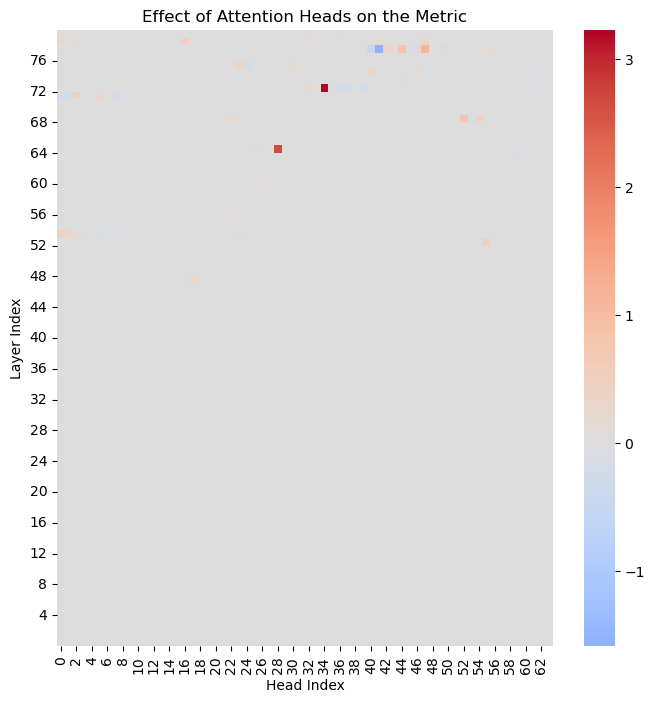

In [20]:
head_effects = attribution_score.mean(dim=0)

# Visualize the effects list using a heatmap
plt.figure(figsize=(8, 8))
sns.heatmap(head_effects.flip(0), cmap="coolwarm", center=0, cbar=True)
plt.xlabel("Head Index")
plt.ylabel("Layer Index")
plt.title("Effect of Attention Heads on the Metric")
plt.yticks(ticks=list(range(4, model.config.num_hidden_layers, 4)), labels=list(range(4, model.config.num_hidden_layers, 4))[::-1])
plt.show()

In [21]:
k = 10
topk_heads = head_effects.view(-1).topk(k, largest=True).indices
top_story_heads = [((idx // model.config.num_attention_heads).item(), (idx % model.config.num_attention_heads).item()) for idx in topk_heads]
for l, h in top_story_heads:
    print(f"Layer {l}, Head {h}")

Layer 72, Head 34
Layer 64, Head 28
Layer 77, Head 47
Layer 77, Head 44
Layer 68, Head 52
Layer 68, Head 54
Layer 78, Head 16
Layer 71, Head 2
Layer 52, Head 55
Layer 53, Head 0


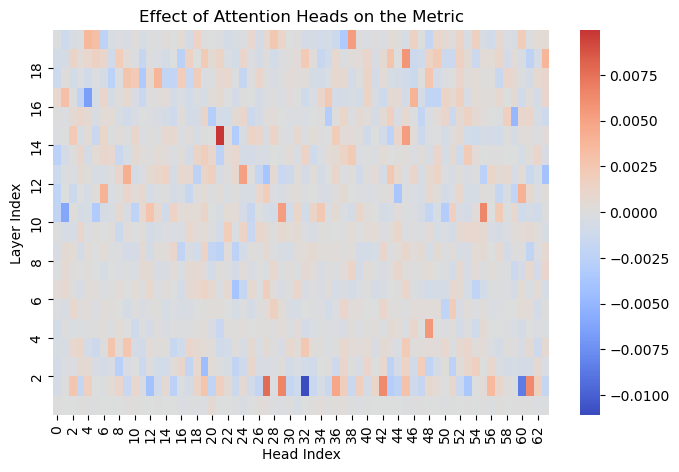

In [193]:
attribution_score = torch.load("story_heads_attribution_score.pt")
story_head_effects = attribution_score.mean(dim=0)

# Visualize the effects list using a heatmap
plt.figure(figsize=(8, 5))
sns.heatmap(story_head_effects.flip(0), cmap="coolwarm", center=0, cbar=True)
plt.xlabel("Head Index")
plt.ylabel("Layer Index")
plt.title("Effect of Attention Heads on the Metric")
plt.yticks(ticks=list(range(2, n_layers, 2)), labels=list(range(2, n_layers, 2))[::-1])
plt.show()

In [198]:
k = 30
topk_heads = story_head_effects.view(-1).topk(k, largest=True).indices
top_story_heads = [((idx // model.config.num_attention_heads).item(), (idx % model.config.num_attention_heads).item()) for idx in topk_heads]
for l, h in top_story_heads:
    print(f"Layer {l}, Head {h}")

Layer 14, Head 21
Layer 1, Head 27
Layer 1, Head 29
Layer 10, Head 55
Layer 1, Head 61
Layer 1, Head 42
Layer 18, Head 45
Layer 4, Head 48
Layer 19, Head 38
Layer 10, Head 29
Layer 14, Head 45
Layer 12, Head 24
Layer 1, Head 36
Layer 12, Head 9
Layer 11, Head 60
Layer 16, Head 46
Layer 11, Head 6
Layer 18, Head 63
Layer 17, Head 13
Layer 19, Head 4
Layer 1, Head 56
Layer 19, Head 5
Layer 16, Head 1
Layer 1, Head 45
Layer 10, Head 12
Layer 18, Head 43
Layer 1, Head 19
Layer 3, Head 7
Layer 17, Head 9
Layer 17, Head 48


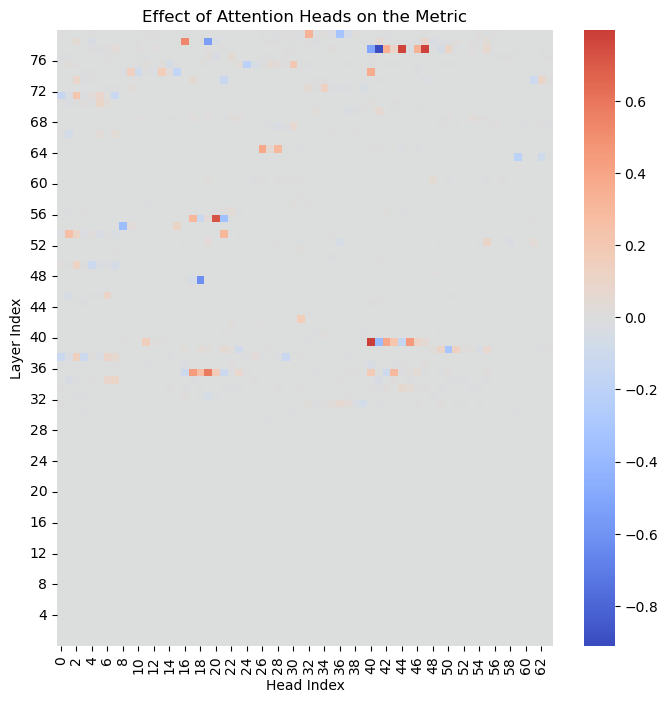

In [22]:
attribution_score = torch.load("option_heads_attribution_score.pt")
option_head_effects = attribution_score.mean(dim=0)

# Visualize the effects list using a heatmap
plt.figure(figsize=(8, 8))
sns.heatmap(option_head_effects.flip(0), cmap="coolwarm", center=0, cbar=True)
plt.xlabel("Head Index")
plt.ylabel("Layer Index")
plt.title("Effect of Attention Heads on the Metric")
plt.yticks(ticks=list(range(4, model.config.num_hidden_layers, 4)), labels=list(range(4, model.config.num_hidden_layers, 4))[::-1])
plt.show()

In [23]:
k = 15
topk_heads = option_head_effects.view(-1).topk(k, largest=True).indices
top_option_heads = [((idx // model.config.num_attention_heads).item(), (idx % model.config.num_attention_heads).item()) for idx in topk_heads]
for l, h in top_option_heads:
    print(f"Layer {l}, Head {h}")

Layer 39, Head 40
Layer 77, Head 47
Layer 77, Head 44
Layer 55, Head 20
Layer 35, Head 19
Layer 78, Head 16
Layer 39, Head 45
Layer 35, Head 17
Layer 39, Head 42
Layer 64, Head 26
Layer 74, Head 40
Layer 77, Head 42
Layer 79, Head 32
Layer 77, Head 46
Layer 55, Head 17


In [11]:
circuit_heads = top_option_heads
print(f"#Heads in circuit: {len(circuit_heads)}")

#Heads in circuit: 10


## Faithfulness

In [43]:
n_samples = 40
batch_size = 1
clean_samples = []
method_name = "0shot"

with open(f"prompt_instructions/{method_name}.txt", "r") as f:
    instructions = f.read()

for example in tb_data[: n_samples//2] + fb_data[: n_samples//2]:
    story, clean_question_raw, correct_answer, wrong_answer = example
    answers = [correct_answer, wrong_answer]
    random.shuffle(answers)

    clean_question = f"{clean_question_raw}\nChoose one of the following:\na) {answers[0]}\nb) {answers[1]}"
    corrupt_question = f"{clean_question_raw}\nChoose one of the following:\na) {answers[1]}\nb) {answers[0]}"

    clean_prompt = f"Instructions: {instructions}\nStory: {story}\nQuestion: {clean_question}\nAnswer:"
    corrupt_prompt = f"Instructions: {instructions}\nStory: {story}\nQuestion: {corrupt_question}\nAnswer:"

    if answers[0] == correct_answer:
        clean_target = " a"
        corrupt_target = " b"
    else:
        clean_target = " b"
        corrupt_target = " a"

    clean_samples.append({"clean_prompt": clean_prompt, "clean_target": clean_target, "corrupt_prompt": corrupt_prompt, "corrupt_target": corrupt_target})

# Create dataloader using clean_samples
dataset = Dataset.from_list(clean_samples)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

In [44]:
d_head = model.config.hidden_size // model.config.num_attention_heads
mean_act = torch.zeros(model.config.num_hidden_layers, model.config.num_attention_heads, d_head)

with torch.no_grad():
    for batch in tqdm(dataloader):
        clean_prompt = batch["clean_prompt"]
        with model.trace(clean_prompt, scan=False, validate=False):
            for layer_idx in range(model.config.num_hidden_layers):
                head_out = model.model.layers[layer_idx].self_attn.o_proj.input[0][0]
                head_out = rearrange(head_out, 
                                     "batch seqlen (n_heads d_head) -> batch seqlen n_heads d_head", 
                                     n_heads=model.config.num_attention_heads)
                head_out = head_out.sum(dim=0)[-1]
                mean_act[layer_idx] += head_out.save()

    for layer_idx in range(model.config.num_hidden_layers):
        for head_idx in range(model.config.num_attention_heads):
            mean_act[layer_idx][head_idx] = mean_act[layer_idx][head_idx] / len(dataloader.dataset)

100%|██████████| 40/40 [01:59<00:00,  2.99s/it]


In [45]:
mean_act.shape

torch.Size([80, 64, 128])

In [57]:
accs = {}

with torch.no_grad():
    correct, total = 0, 0
    for batch in tqdm(dataloader):
        prompt = batch["clean_prompt"]
        target = batch["clean_target"]

        with model.trace(prompt, scan=False, validate=False):
            for layer_idx in range(model.config.num_hidden_layers):
                head_out = model.model.layers[layer_idx].self_attn.o_proj.input[0][0]
                head_out = rearrange(head_out, "batch seqlen (n_heads d_head) -> batch seqlen n_heads d_head", 
                                     n_heads=model.config.num_attention_heads)

                for head_idx in range(model.config.num_attention_heads):
                    if (layer_idx, head_idx) not in topk_heads: 
                        head_out[:, -1, head_idx] = mean_act[layer_idx, head_idx]

                head_out = rearrange(head_out, "batch seqlen n_heads d_head -> batch seqlen (n_heads d_head)", 
                                     n_heads=model.config.num_attention_heads)

                model.model.layers[layer_idx].self_attn.o_proj.output = model.model.layers[layer_idx].self_attn.o_proj(
                                                                            head_out
                                                                        )

            preds = model.lm_head.output[:, -1].argmax(dim=-1).save()

        for i in range(len(target)):
            if model.tokenizer.decode(preds[i].item()).strip() == target[i].strip():
                correct += 1
            total += 1

    acc = round(correct/total, 2)
    print(f"Acc: {acc}")
#     accs[(l, h)] = acc

100%|██████████| 20/20 [01:04<00:00,  3.21s/it]

Acc: 0.55


In [15]:
accs

{(39, 40): 0.9,
 (77, 47): 0.45,
 (77, 44): 0.45,
 (55, 20): 0.45,
 (35, 19): 0.9,
 (78, 16): 0.45,
 (39, 45): 0.93,
 (35, 17): 0.85,
 (39, 42): 0.85,
 (64, 26): 0.45}

## Path Patching

In [111]:
n_samples = 10
batch_size = 1
samples = get_data_pp(tb_data+fb_data, n_samples=n_samples)

dataset = Dataset.from_list(samples)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

In [93]:
print(samples[0]['clean_prompt'], samples[0]['clean_target'])

Instructions: Keep track of people's knowledge defined in the story. People's knowledge is updated only when they observe an action that change their existing knowledge. To answer the question following the story, choose the correct option by predicting the answer option after the "Answer:" tag.

Story: Aria is a talented baker from Italy who has been asked to bake a cake for a friend's birthday party. She wants to create a delicious, multi-layered cake that will impress everyone. Aria has a fresh batch of ingredients ready to use for the cake. However, a mischievous cat sneaks into her kitchen and nibbles on some of the ingredients, making them no longer fresh. Aria sees the cat and the nibbled ingredients.
Question: Does Aria believe her ingredients are fresh and suitable or nibbled on and no longer fresh?
Choose one of the following:
a)Aria believes her ingredients are fresh and suitable for baking the cake.
b)Aria believes the ingredients are nibbled on and no longer fresh.
Answer:

In [94]:
print(samples[0]['corrupt_prompt'], samples[0]['corrupt_target'])

Instructions: Keep track of people's knowledge defined in the story. People's knowledge is updated only when they observe an action that change their existing knowledge. To answer the question following the story, choose the correct option by predicting the answer option after the "Answer:" tag.

Story: Dalia is a professional photographer, setting up her equipment for a wedding photoshoot. She wants to capture stunning photos with her high-quality camera. Dalia sees that the camera lens appears clean and free of smudges. While Dalia is away, a mischievous child plays with the camera, leaving fingerprints all over the lens. Dalia notices the fingerprints on the camera lens.
Question: Does Dalia believe the camera lens is clean and free of smudges or covered in fingerprints?
Choose one of the following:
x)Dalia believes the camera lens is covered in fingerprints.
y)Dalia believes the camera lens is clean and free of smudges.
Answer:  a


##### Heads Impact End of Residual Stream

In [46]:
downstream_nodes = [model.lm_head]
upstream_nodes = [model.model.layers[l].self_attn.o_proj for l in range(model.config.num_hidden_layers)]
attribution_score = torch.zeros(
    len(dataloader), model.config.num_hidden_layers, model.config.num_attention_heads
).cpu()

for batch_idx, batch in tqdm(enumerate(dataloader), total=len(dataloader)):
    clean_prompt = batch["clean_prompt"]
    corrupt_prompt = batch["corrupt_prompt"]
    clean_target = batch["clean_target"]
    corrupt_target = batch["corrupt_target"]

    # Computing the upstream activations and downstream gradients on clean prompt
    upstream_act_clean, downstream_grads = {}, {}
    with model.trace(clean_prompt, scan=False, validate=False):
        for node in upstream_nodes:
            node_name = node._module_path[1:]
            head_out = node.input[0][0]
            upstream_act_clean[node_name] = head_out.cpu().save()

        for node in downstream_nodes:
            node_name = node._module_path[1:]
            downstream_grads[node_name] = node.input[0][0].grad.cpu().save()

        metric_clean = metric_fn(model, clean_target, corrupt_target)
        metric_clean.sum().backward()

    upstream_act_clean = {k: v.value.cpu() for k, v in upstream_act_clean.items()}
    downstream_grads = {k: v.value.cpu() for k, v in downstream_grads.items()}

    model.zero_grad(set_to_none=True)
    torch.cuda.empty_cache()

    # Computing gradients of upstream ndoes wrt downstream nodes on clean prompt
    upstream_grads = defaultdict(dict)
    for downstream_node in downstream_nodes:
        downstream_node_name = downstream_node._module_path[1:]

        with model.trace(clean_prompt, scan=False, validate=False):
            for upstream_node in upstream_nodes:
                upstream_node_name = upstream_node._module_path[1:]
                upstream_grads[downstream_node_name][upstream_node_name] = (
                    upstream_node.input[0][0].grad.cpu().save()
                )

            metric_score = downstream_node.input[0][0][:, -1].mean(0).sum(0)
            metric_score.backward()

        upstream_grads[downstream_node_name] = {
            k: v.value.cpu() for k, v in upstream_grads[downstream_node_name].items()
        }

        model.zero_grad(set_to_none=True)
        torch.cuda.empty_cache()


    # Computing the upstream activations for corrupt prompt
    upstream_act_corrupt = {}
    with torch.no_grad():
        with model.trace(
            corrupt_prompt, scan=False, validate=False
        ), torch.inference_mode():
            for node in upstream_nodes:
                node_name = node._module_path[1:]
                head_out = node.input[0][0]
                upstream_act_corrupt[node_name] = head_out.cpu().save()

            metric_corrupt = metric_fn(model, clean_target, corrupt_target)

    upstream_act_corrupt = {k: v.value.cpu() for k, v in upstream_act_corrupt.items()}

    torch.cuda.empty_cache()

    
    # Computing the attribution score
    for downstream_node in downstream_nodes:
        downstream_node_name = downstream_node._module_path[1:]
        downstream_grad = downstream_grads[downstream_node_name]

        d_head = model.config.hidden_size // model.config.num_attention_heads
        with torch.no_grad(), torch.inference_mode():
            for upstream_node in upstream_nodes:
                upstream_node_name = upstream_node._module_path[1:]
                clean_state, corrupt_state = (
                    upstream_act_clean[upstream_node_name],
                    upstream_act_corrupt[upstream_node_name],
                )
                upstream_grad = upstream_grads[downstream_node_name][upstream_node_name]
                
                corrupt_state = corrupt_state.mean(dim=0)[-1]
                clean_state = clean_state.mean(dim=0)[-1]

                delta = (corrupt_state - clean_state).detach()
                score = downstream_grad * upstream_grad * delta

                # Averaging over all batch items and analysing components only at last token position
                score = score.mean(dim=0)[-1]
                score = rearrange(
                    score,
                    "(n_heads d_head) -> n_heads d_head",
                    n_heads=model.config.num_attention_heads,
                )
                score = reduce(score, "n_heads d_head -> n_heads", "sum")
                
                layer_idx = int(upstream_node_name.split('.')[2])
                attribution_score[batch_idx][layer_idx] = score

            del (
                upstream_act_clean[upstream_node_name],
                upstream_act_corrupt[upstream_node_name],
                upstream_grads[downstream_node_name][upstream_node_name],
                clean_state,
                corrupt_state,
                score,
            )
            torch.cuda.empty_cache()

100%|██████████| 100/100 [1:18:02<00:00, 46.83s/it]


In [131]:
attribution_score = torch.load("heads_affecting_final_out.pt")
effects = attribution_score.mean(dim=0)

k = 10
top_indices = effects.view(-1).topk(k, largest=True).indices
head_affect_final_out = [((idx // model.config.num_attention_heads).item(), (idx % model.config.num_attention_heads).item()) for idx in top_indices]

for l, h in head_affect_final_out:
    print(f"Layer {l}, Head {h}")

Layer 73, Head 62
Layer 47, Head 17
Layer 75, Head 24
Layer 35, Head 19
Layer 75, Head 30
Layer 39, Head 13
Layer 38, Head 50
Layer 47, Head 18
Layer 73, Head 0
Layer 60, Head 26


In [ ]:
# Visualize the effects list using a heatmap
plt.figure(figsize=(8, 8))
sns.heatmap(effects.flip(0), cmap="coolwarm", center=0, cbar=True)
plt.xlabel("Head Index")
plt.ylabel("Layer Index")
plt.title("Effect of Attention Heads on the Metric")
plt.yticks(
    ticks=list(range(4, model.config.num_hidden_layers, 4)),
    labels=list(range(4, model.config.num_hidden_layers, 4))[::-1],
)
plt.show()

##### Heads impacting letter attending heads 

In [128]:
# attribution_score = torch.load("heads_affecting_final_out.pt")
# effects = attribution_score.mean(dim=0)

# k = 10
# top_indices = effects.view(-1).topk(k, largest=True).indices
# head_affect_final_out = [((idx // model.config.num_attention_heads).item(), (idx % model.config.num_attention_heads).item()) for idx in top_indices]

# # downstream_nodes = [model.model.layers[l].self_attn.q_proj for l, h in topk_heads]

In [97]:
attribution_score = torch.zeros(
    len(dataloader), model.config.num_hidden_layers, model.config.num_attention_heads
).cpu()

for batch_idx, batch in tqdm(enumerate(dataloader), total=len(dataloader)):
    clean_prompt = batch["clean_prompt"]
    corrupt_prompt = batch["corrupt_prompt"]
    clean_target = batch["clean_target"]
    corrupt_target = batch["corrupt_target"]

    # Computing the upstream activations and downstream gradients on clean prompt
    upstream_act_clean, downstream_grads = {}, {}
    with model.trace(clean_prompt, scan=False, validate=False):
        for layer_idx in range(model.config.num_hidden_layers):
            head_out = model.model.layers[layer_idx].self_attn.o_proj.input[0][0]
            head_out = rearrange(head_out,
                                "batch seqlen (n_heads d_head) -> batch seqlen n_heads d_head",
                                 n_heads=model.config.num_attention_heads)

            head_q_grad = model.model.layers[layer_idx].self_attn.q_proj.input[0][0].grad
            head_q_grad = rearrange(head_q_grad, 
                                    "batch seqlen (n_heads d_head) -> batch seqlen n_heads d_head",
                                     n_heads=model.config.num_attention_heads)

            for head_idx in range(model.config.num_attention_heads):
                upstream_act_clean[(layer_idx, head_idx)] = head_out[:, -1, head_idx].cpu().save()
                downstream_grads[(layer_idx, head_idx)] = head_q_grad[:, -1, head_idx].cpu().save()

        metric_clean = metric_fn(model, clean_target, corrupt_target)
        metric_clean.sum().backward()

    upstream_act_clean = {k: v.value.cpu() for k, v in upstream_act_clean.items()}
    downstream_grads = {k: v.value.cpu() for k, v in downstream_grads.items()}

    model.zero_grad(set_to_none=True)
    torch.cuda.empty_cache()

    # Computing gradients of upstream nodes wrt downstream nodes on clean prompt
    upstream_grads = defaultdict(dict)
    for l, h in topk_heads:
        with model.trace(clean_prompt, scan=False, validate=False):
            for layer_idx in range(l):
                head_grad = model.model.layers[layer_idx].self_attn.o_proj.input[0][0].grad
                head_grad = rearrange(head_grad, 
                                    "batch seqlen (n_heads d_head) -> batch seqlen n_heads d_head",
                                     n_heads=model.config.num_attention_heads)

                for head_idx in range(model.config.num_attention_heads):
                    upstream_grads[(l, h)][(layer_idx, head_idx)] = head_grad[:, -1, head_idx].cpu().save()
            
            downstream_node_out = model.model.layers[l].self_attn.q_proj.input[0][0][:, -1]
            downstream_node_out = rearrange(downstream_node_out, 
                                    "batch (n_heads d_head) -> batch n_heads d_head",
                                     n_heads=model.config.num_attention_heads)
            metric_score = downstream_node_out[:, h].mean(0).sum(0)
            metric_score.backward()
        
        upstream_grads[(l, h)] = {
            k: v.value.cpu() for k, v in upstream_grads[(l, h)].items()
        }
        model.zero_grad(set_to_none=True)
        torch.cuda.empty_cache()

    # Computing the upstream activations for corrupt prompt
    upstream_act_corrupt = {}
    with torch.no_grad():
        with model.trace(corrupt_prompt, scan=False, validate=False):
            for layer_idx in range(model.config.num_hidden_layers):
                head_out = model.model.layers[layer_idx].self_attn.o_proj.input[0][0]
                head_out = rearrange(head_out,
                                    "batch seqlen (n_heads d_head) -> batch seqlen n_heads d_head",
                                     n_heads=model.config.num_attention_heads)

                for head_idx in range(model.config.num_attention_heads):
                    upstream_act_corrupt[(layer_idx, head_idx)] = head_out[:, -1, head_idx].cpu().save()
        
        upstream_act_corrupt = {k: v.value.cpu() for k, v in upstream_act_corrupt.items()}
        torch.cuda.empty_cache()
    
    # Computing the attribution score
    for l, h in topk_heads:
        downstream_grad = downstream_grads[(l, h)]

        d_head = model.config.hidden_size // model.config.num_attention_heads
        with torch.no_grad(), torch.inference_mode():
            for layer_idx in range(l):
                for head_idx in range(model.config.num_attention_heads):
                    clean_state = upstream_act_clean[(layer_idx, head_idx)]
                    corrupt_state = upstream_act_corrupt[(layer_idx, head_idx)]
                    upstream_grad = upstream_grads[(l, h)][(layer_idx, head_idx)]

                    clean_state = clean_state.mean(dim=0)
                    corrupt_state = corrupt_state.mean(dim=0)
                    upstream_grad = upstream_grad.mean(dim=0)
                    
                    delta = (corrupt_state - clean_state).detach()
                    score = downstream_grad * upstream_grad * delta
                    attribution_score[batch_idx, layer_idx, head_idx] += score.sum()

            del (
                upstream_grads[(l, h)],
                clean_state,
                corrupt_state,
                score,
            )
            torch.cuda.empty_cache()
    
    del upstream_act_clean, upstream_act_corrupt, upstream_grads
    torch.cuda.empty_cache()

100%|██████████| 100/100 [1:01:48<00:00, 37.08s/it]


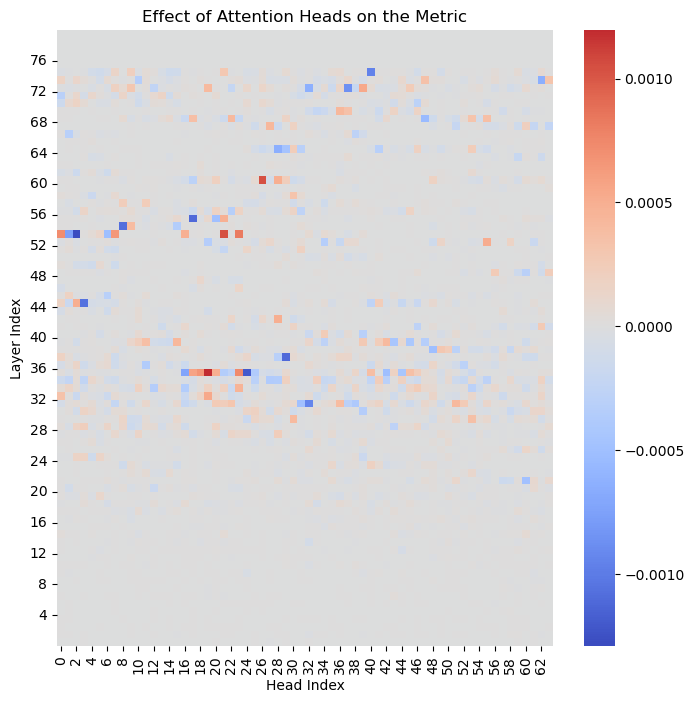

In [118]:
attribution_score = torch.load("heads_affect_letter_attending_heads.pt")
effects = attribution_score.mean(dim=0)

# Visualize the effects list using a heatmap
plt.figure(figsize=(8, 8))
sns.heatmap(effects.flip(0), cmap="coolwarm", center=0, cbar=True)
plt.xlabel("Head Index")
plt.ylabel("Layer Index")
plt.title("Effect of Attention Heads on the Metric")
plt.yticks(
    ticks=list(range(4, model.config.num_hidden_layers, 4)),
    labels=list(range(4, model.config.num_hidden_layers, 4))[::-1],
)
plt.show()

In [127]:
k = 10
top_indices = effects.view(-1).topk(k, largest=True).indices
heads_affecting_letter_heads = [((idx // model.config.num_attention_heads).item(), (idx % model.config.num_attention_heads).item()) for idx in top_indices]
for l, h in heads_affecting_letter_heads:
    print(f"Layer {l}, Head {h}")

Layer 35, Head 19
Layer 53, Head 21
Layer 60, Head 26
Layer 53, Head 23
Layer 35, Head 23
Layer 53, Head 0
Layer 35, Head 18
Layer 53, Head 7
Layer 35, Head 17
Layer 72, Head 39


In [125]:
circuit_heads = heads_affecting_letter_heads + head_affect_final_out
print(f"Circuit size: {len(circuit_heads)}")

Circuit size: 1


In [63]:
# d_head = model.config.hidden_size // model.config.num_attention_heads
# mean_act = torch.zeros(model.config.num_hidden_layers, model.config.num_attention_heads, d_head)

# with torch.no_grad():
#     for batch in tqdm(dataloader):
#         clean_prompt = batch["clean_prompt"]
#         corrupt_prompt = batch["corrupt_prompt"]

#         with model.trace(clean_prompt, scan=False, validate=False):
#             for layer_idx in range(model.config.num_hidden_layers):
#                 head_out = model.model.layers[layer_idx].self_attn.o_proj.input[0][0]
#                 head_out = rearrange(head_out, 
#                                      "batch seqlen (n_heads d_head) -> batch seqlen n_heads d_head", 
#                                      n_heads=model.config.num_attention_heads)
#                 head_out = head_out.sum(dim=0)[-1]
#                 mean_act[layer_idx] += head_out.save()
        
#         with model.trace(corrupt_prompt, scan=False, validate=False):
#             for layer_idx in range(model.config.num_hidden_layers):
#                 head_out = model.model.layers[layer_idx].self_attn.o_proj.input[0][0]
#                 head_out = rearrange(head_out, 
#                                      "batch seqlen (n_heads d_head) -> batch seqlen n_heads d_head", 
#                                      n_heads=model.config.num_attention_heads)
#                 head_out = head_out.sum(dim=0)[-1]
#                 mean_act[layer_idx] += head_out.save()

#     for layer_idx in range(model.config.num_hidden_layers):
#         for head_idx in range(model.config.num_attention_heads):
#             mean_act[layer_idx][head_idx] = mean_act[layer_idx][head_idx] / (2*len(dataloader.dataset))

In [126]:
correct, total = 0, 0
with torch.no_grad():
    for batch_idx, batch in tqdm(enumerate(dataloader), total=len(dataloader)):
        clean_prompt = batch["clean_prompt"]
        corrupt_prompt = batch["corrupt_prompt"]
        clean_target = batch["clean_target"][0]
        corrupt_target = batch["corrupt_target"][0]

        with model.trace(clean_prompt, scan=False, validate=False):
            for layer_idx in range(model.config.num_hidden_layers):
                head_out = model.model.layers[layer_idx].self_attn.o_proj.input[0][0]
                head_out = rearrange(head_out, 
                                     "batch seqlen (n_heads d_head) -> batch seqlen n_heads d_head",
                                    n_heads=model.config.num_attention_heads)
    
                for head_idx in range(model.config.num_attention_heads):
                    if (layer_idx, head_idx) not in circuit_heads:
                        head_out[:, -1, head_idx] = mean_act[layer_idx, head_idx]

                head_out = rearrange(head_out, 
                             "batch seqlen n_heads d_head -> batch seqlen (n_heads d_head)",
                            n_heads=model.config.num_attention_heads)

                model.model.layers[layer_idx].self_attn.o_proj.output = model.model.layers[layer_idx].self_attn.o_proj(head_out)

            preds = model.lm_head.output[:, -1].argmax(dim=-1).save()

        torch.cuda.empty_cache()

        print(f"Prediction: {model.tokenizer.decode([preds])} | Target: {clean_target}")
        if model.tokenizer.decode([preds]).strip() == clean_target.strip():
            correct += 1
        total += 1

    acc = round(correct/total, 2)
    print(f"Acc: {acc}")   

 10%|█         | 1/10 [00:03<00:28,  3.18s/it]

Prediction:  b | Target:  b


 20%|██        | 2/10 [00:05<00:23,  2.94s/it]

Prediction:  a | Target:  a


 30%|███       | 3/10 [00:08<00:20,  2.87s/it]

Prediction:  a | Target:  a


 40%|████      | 4/10 [00:11<00:17,  2.98s/it]

Prediction:  a | Target:  a


 50%|█████     | 5/10 [00:14<00:14,  2.90s/it]

Prediction:  b | Target:  b


 60%|██████    | 6/10 [00:17<00:11,  2.86s/it]

Prediction:  a | Target:  a


 70%|███████   | 7/10 [00:20<00:09,  3.01s/it]

Prediction:  a | Target:  a


 80%|████████  | 8/10 [00:24<00:06,  3.22s/it]

Prediction:  b | Target:  b


 90%|█████████ | 9/10 [00:27<00:03,  3.09s/it]

Prediction:  b | Target:  b


100%|██████████| 10/10 [00:29<00:00,  3.00s/it]

Prediction:  b | Target:  b
Acc: 1.0


In [49]:
del corrupt_head_out
torch.cuda.empty_cache()